In [100]:
import pandas as pd
from rdkit import Chem
import networkx as nx
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import combinations
import random

**Dataset loading and processing**

In [101]:
# Load the dataset
dataset = pd.read_csv('SAMPL.csv')

# Display the first few rows to verify loading
print(dataset.head())

# Check if the dataset contains a column for SMILES strings
if 'smiles' not in dataset.columns:
    raise ValueError("The dataset does not contain a 'smiles' column.")

# Convert SMILES strings to RDKit molecule objects.Store them in a new column called 'molecule'
dataset['molecule'] = dataset['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# Verify the conversion by showing the first few molecules
print(dataset[['smiles', 'molecule']].head())

                              iupac                  smiles   expt   calc
0  4-methoxy-N,N-dimethyl-benzamide  CN(C)C(=O)c1ccc(cc1)OC -11.01 -9.625
1          methanesulfonyl chloride            CS(=O)(=O)Cl  -4.87 -6.219
2                 3-methylbut-1-ene                CC(C)C=C   1.83  2.452
3                   2-ethylpyrazine              CCc1cnccn1  -5.45 -5.809
4                       heptan-1-ol                CCCCCCCO  -4.21 -2.917
                   smiles                                           molecule
0  CN(C)C(=O)c1ccc(cc1)OC  <rdkit.Chem.rdchem.Mol object at 0x000002C5F03...
1            CS(=O)(=O)Cl  <rdkit.Chem.rdchem.Mol object at 0x000002C5F03...
2                CC(C)C=C  <rdkit.Chem.rdchem.Mol object at 0x000002C5F03...
3              CCc1cnccn1  <rdkit.Chem.rdchem.Mol object at 0x000002C5F03...
4                CCCCCCCO  <rdkit.Chem.rdchem.Mol object at 0x000002C5F03...


In [102]:
# Check if the dataset contains a column for SMILES strings
if 'smiles' not in dataset.columns:
    raise ValueError("The dataset does not contain a 'smiles' column.")

# Extended smiles_to_graph function using NetworkX
def smiles_to_networkx(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid molecules

    graph = nx.Graph()
    
    # Add nodes with features
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), 
                       atomic_num=atom.GetAtomicNum(),
                       degree=atom.GetDegree(),
                       hybridization=str(atom.GetHybridization()),
                       is_aromatic=atom.GetIsAromatic())

    # Add edges with features
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        graph.add_edge(start, end, 
                       bond_type=str(bond.GetBondType()),
                       is_conjugated=bond.GetIsConjugated(),
                       is_aromatic=bond.GetIsAromatic())

    return graph

# Apply the function to the SMILES column and store the results
dataset['networkx_graph'] = dataset['smiles'].apply(smiles_to_networkx)

# Remove rows where SMILES could not be converted to a graph
dataset = dataset[dataset['networkx_graph'].notnull()].reset_index(drop=True)

# Verify the graph construction for a few molecules
for idx, row in dataset.head().iterrows():
    print(f"Molecule: {row['iupac']}")
    print(f"Number of Nodes: {len(row['networkx_graph'].nodes)}")
    print(f"Number of Edges: {len(row['networkx_graph'].edges)}")
    print(f"Sample Node Features: {row['networkx_graph'].nodes[0]}")
    print("-" * 50)

Molecule: 4-methoxy-N,N-dimethyl-benzamide
Number of Nodes: 13
Number of Edges: 13
Sample Node Features: {'atomic_num': 6, 'degree': 1, 'hybridization': 'SP3', 'is_aromatic': False}
--------------------------------------------------
Molecule: methanesulfonyl chloride
Number of Nodes: 5
Number of Edges: 4
Sample Node Features: {'atomic_num': 6, 'degree': 1, 'hybridization': 'SP3', 'is_aromatic': False}
--------------------------------------------------
Molecule: 3-methylbut-1-ene
Number of Nodes: 5
Number of Edges: 4
Sample Node Features: {'atomic_num': 6, 'degree': 1, 'hybridization': 'SP3', 'is_aromatic': False}
--------------------------------------------------
Molecule: 2-ethylpyrazine
Number of Nodes: 8
Number of Edges: 8
Sample Node Features: {'atomic_num': 6, 'degree': 1, 'hybridization': 'SP3', 'is_aromatic': False}
--------------------------------------------------
Molecule: heptan-1-ol
Number of Nodes: 8
Number of Edges: 7
Sample Node Features: {'atomic_num': 6, 'degree': 1, '

In [103]:
def create_all_pairs(dataset):
    # Create all possible pairs of rows
    pairs = []
    # Use itertools.combinations to get all unique pairs (order doesn't matter for GED)
    for (idx1, row1), (idx2, row2) in combinations(dataset.iterrows(), 2):
        pairs.append({
            "molecule_1": row1['iupac'],
            "molecule_2": row2['iupac'],
            "row_1": idx1,
            "row_2": idx2,
            # We don't strictly need property_diff for GED training, but can keep it if useful
            "expt_1": row1.get('expt', 0), 
            "expt_2": row2.get('expt', 0),
            "property_diff": abs(row1.get('expt', 0) - row2.get('expt', 0))
        })
    
    return pairs

# Generate pairs based on 'expt'
property_pairs = create_all_pairs(dataset)
print(f"Total pairs generated: {len(property_pairs)}")


Total pairs generated: 205120


In [ ]:
#Identify unique atomic numbers in the dataset and determine max label index
unique_labels = set()

for Graf in dataset['networkx_graph']:
    for _, node_data in Graf.nodes(data=True):
        label = node_data.get('atomic_num') 
        if label is not None:
            val = label[0] if isinstance(label, list) else label
            unique_labels.add(int(val))

max_label = max(unique_labels)
num_unique = len(unique_labels)
print(f"Unique atomic numbers found: {sorted(list(unique_labels))}")
print(f"Max label index: {max_label}")

Unique atomic numbers found: [6, 7, 8, 9, 15, 16, 17, 35, 53]
Max label index: 53


In [105]:
selected_pairs = property_pairs if len(property_pairs) < 10000 else random.sample(property_pairs, 10000)
print(f"Selected {len(selected_pairs)} pairs for training.")

# Display the selected pairs
for i, pair in enumerate(selected_pairs):
    print(f"Pair {i + 1}:")
    print(f"  Molecule 1: {pair['molecule_1']} (Row: {pair['row_1']}, Expt: {pair['expt_1']})")
    print(f"  Molecule 2: {pair['molecule_2']} (Row: {pair['row_2']}, Expt: {pair['expt_2']})")
    print(f"  Property Difference: {pair['property_diff']}")
    print("-" * 50)


Selected 10000 pairs for training.
Pair 1:
  Molecule 1: 4-propylguaiacol (Row: 319, Expt: -5.26)
  Molecule 2: 2-methylpyrazine (Row: 424, Expt: -5.51)
  Property Difference: 0.25
--------------------------------------------------
Pair 2:
  Molecule 1: 1,4-dichlorobenzene (Row: 336, Expt: -1.01)
  Molecule 2: 1,4-dioxane (Row: 640, Expt: -5.06)
  Property Difference: 4.05
--------------------------------------------------
Pair 3:
  Molecule 1: 1,4-diamino-9,10-anthracenedione (Row: 246, Expt: -11.85)
  Molecule 2: alachlor (Row: 310, Expt: -8.21)
  Property Difference: 3.639999999999999
--------------------------------------------------
Pair 4:
  Molecule 1: 1-pyrrolidin-1-ylethanone (Row: 177, Expt: -9.8)
  Molecule 2: 1-iodobutane (Row: 623, Expt: -0.25)
  Property Difference: 9.55
--------------------------------------------------
Pair 5:
  Molecule 1: 2-hydroxybenzaldehyde (Row: 46, Expt: -4.68)
  Molecule 2: 3,5,5-trimethylcyclohex-2-en-1-one (Row: 317, Expt: -5.18)
  Property Di

**Cost matrix functionality to create the cost matrix**

In [ ]:
def create_cost_matrix(graph1, graph2, costs):
    """Create a cost matrix for graph edit distance calculation."""
    num_nodes1 = len(graph1.nodes)
    num_nodes2 = len(graph2.nodes)
    size = num_nodes1 + num_nodes2
    cost_matrix = np.full((size, size), np.inf)  # Initialize with infinity

    # Upper Left: Node Substitution Costs + Edge Insertions/Deletions
    for i, node1 in enumerate(graph1.nodes(data=True)):
        for j, node2 in enumerate(graph2.nodes(data=True)):
            if node1[1]['atomic_num'] != node2[1]['atomic_num']:  # If atomic numbers differ
                cost_matrix[i, j] = costs["node_substitution"]
            else:
                cost_matrix[i, j] = 0.0  # No cost if nodes match

            # Compute edge insertions and deletions
            degree1 = graph1.degree[node1[0]]
            degree2 = graph2.degree[node2[0]]

            if degree1 > degree2:  # More edges in G1 → Need to delete extra edges
                cost_matrix[i, j] += (degree1 - degree2) * costs["edge_deletion"]
            elif degree2 > degree1:  # More edges in G2 → Need to insert extra edges
                cost_matrix[i, j] += (degree2 - degree1) * costs["edge_insertion"]

    # Upper Right: Node Deletion Costs + Edge Deletion Costs
    for i in range(num_nodes1):
        num_incident_edges = graph1.degree[i]  # Count edges connected to this node
        cost_matrix[i, num_nodes2 + i] = costs["node_deletion"] + (num_incident_edges * costs["edge_deletion"])

    # Lower Left: Node Insertion Costs + Edge Insertion Costs
    for j in range(num_nodes2):
        num_incident_edges = graph2.degree[j]  # Count edges connected to this node
        cost_matrix[num_nodes1 + j, j] = costs["node_insertion"] + (num_incident_edges * costs["edge_insertion"])

    # Bottom Right: Placeholder Matches (Fully Zero Block)
    for i in range(num_nodes1, size):
        for j in range(num_nodes2, size):
            cost_matrix[i, j] = 0.0

    return cost_matrix


**Approximate GED using bipartite graph matching**

In [107]:
costs = {
    "node_substitution": 10.0,  # Fixed substitution cost
    "node_insertion": 5.0,    # Fixed insertion cost
    "node_deletion": 3.0,    # Fixed deletion cost
    "edge_insertion":3.0,    # Fixed edge insertion cost
    "edge_deletion":2.0,     # Fixed edge deletion cost
    "edge_substitution":7.0  # Fixed edge substitution cost
}
def compute_bipartite_ged(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Compute total matching cost (GED estimate)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    matching_pairs = list(zip(row_ind, col_ind))
    
    return total_cost, matching_pairs

# Loop through the 300 selected pairs and calculate GED for each
ged_results = []

for index, pair in enumerate(selected_pairs):
    # Fetch the graphs based on the selected pairs
    graph1 = dataset.iloc[pair['row_1']]['networkx_graph']
    graph2 = dataset.iloc[pair['row_2']]['networkx_graph']
    molecule1_name = dataset.iloc[pair['row_1']]['iupac']
    molecule2_name = dataset.iloc[pair['row_2']]['iupac']
    
    # Generate the cost matrix for the pair
    cost_matrix = create_cost_matrix(graph1, graph2, costs)
    
    # Compute the approximate GED using bipartite matching
    approximate_ged, matching_pairs = compute_bipartite_ged(cost_matrix)
    pair['approximate_ged'] = approximate_ged 
    # Store results in a list
    ged_results.append({
        "molecule_1": molecule1_name,
        "molecule_2": molecule2_name,
        "approximate_ged": approximate_ged,
    })

# Display results for all pairs
for result in ged_results:
    print(f"{result['molecule_1']} vs {result['molecule_2']} - Approx. GED: {result['approximate_ged']}")

4-propylguaiacol vs 2-methylpyrazine - Approx. GED: 55.0
1,4-dichlorobenzene vs 1,4-dioxane - Approx. GED: 34.0
1,4-diamino-9,10-anthracenedione vs alachlor - Approx. GED: 33.0
1-pyrrolidin-1-ylethanone vs 1-iodobutane - Approx. GED: 35.0
2-hydroxybenzaldehyde vs 3,5,5-trimethylcyclohex-2-en-1-one - Approx. GED: 26.0
methyl benzoate vs hexan-1-amine - Approx. GED: 35.0
1-cyclohexylethanone vs 5-chlorouracil - Approx. GED: 45.0
1,2,3,4,7-pentachlorodibenzo-p-dioxin vs 1-amino-4-hydroxy-9,10-anthracenedione - Approx. GED: 57.0
nonan-2-one vs 2-bromopropane - Approx. GED: 52.0
tetrahydropyran vs 2,3,4-trimethylpentane - Approx. GED: 41.0
pentylbenzene vs 2-methoxyethanamine - Approx. GED: 66.0
2-methoxy-2-methyl-propane vs acetaldehyde - Approx. GED: 21.0
4-ethylpyridine vs 1,3,5-trichloro-2-phenyl-benzene - Approx. GED: 93.0
1,1-difluoroethane vs 4-chlorophenol - Approx. GED: 70.0
1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene vs 1-iodobutane - Approx. GED: 109.0
1,2-dinitroxypropane 

In [108]:
def graph_to_multiset(graph):
    """
    Converts a NetworkX graph to a multiset of (atomic_num, degree) tuples.
    """
    multiset = []
    for node, data in graph.nodes(data=True):
        # atomic_num is already in data from smiles_to_networkx
        # degree is also there, or we can compute it
        atomic_num = data.get('atomic_num', 0)
        degree = graph.degree[node]
        multiset.append([atomic_num, degree])
    return torch.tensor(multiset, dtype=torch.float32)

# Prepare data
X1_list = []
X2_list = []
Y_list = []

max_nodes = 0

for pair in selected_pairs:
    # Get graphs
    g1 = dataset.iloc[pair['row_1']]['networkx_graph']
    g2 = dataset.iloc[pair['row_2']]['networkx_graph']
    
    # Get GED
    ged = pair['approximate_ged']
    
    # Convert to multisets
    m1 = graph_to_multiset(g1)
    m2 = graph_to_multiset(g2)
    
    X1_list.append(m1)
    X2_list.append(m2)
    Y_list.append(ged)
    
    max_nodes = max(max_nodes, m1.shape[0], m2.shape[0])

**Architectures**

In [ ]:
# small MLP head mapping pair of embeddings -> scalar cost
class Head(nn.Module):
    """Simple MLP head for pair of embeddings to scalar cost"""
    def __init__(self, emb_dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim * 4, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, u, v):
        x = torch.cat([u, v, torch.abs(u - v), u * v], dim=1)
        out = self.net(x)
        return out.squeeze(1)


class DeepSets(nn.Module):
    """DeepSets model for set input processing"""
    def __init__(self, input_dim, hidden_dim, output_dim, aggregator='sum', dropout=0.0):
        super().__init__()
        self.psi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

        self.aggregator = aggregator

        self.phi = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, mask=None, return_per_point=False):
        # x: (B, N, D)
        B, N, D = x.shape
        x_flat = x.view(B * N, D)
        h_flat = self.psi(x_flat)                   # (B*N, hidden_dim)
        h = h_flat.view(B, N, -1)    
        
        if mask is not None:
            mask_expanded = mask.unsqueeze(-1).float()  # (B, N, 1)
            h = h * mask_expanded  # zero out padding

        if self.aggregator == 'sum':
            pooled = h.sum(dim=1)
        elif self.aggregator == 'mean':
            if mask is not None:
                # mean over real points only
                counts = mask.sum(dim=1, keepdim=True).float().clamp(min=1.0)  # (B, 1)
                pooled = h.sum(dim=1) / counts
            else:
                pooled = h.mean(dim=1)
        elif self.aggregator == 'max':
            if mask is not None:
                h_masked = h.clone()
                h_masked[~mask.unsqueeze(-1).expand_as(h)] = -1e9
                pooled = h_masked.max(dim=1)[0]
            else:
                pooled = h.max(dim=1)[0]
        else:
            raise ValueError("Unknown aggregator")
        out = self.phi(pooled)                      # (B, output_dim)
        if return_per_point:
            return out, h                           # (B, output_dim), (B, N, hidden_dim)
        return out
    
class SinkhornGED(nn.Module):
    """Sinkhorn-based Graph Edit Distance model with ICPR 2022 tricks"""
    def __init__(self, input_dim, hidden_dim, sinkhorn_iter=10, epsilon=0.5):
        super().__init__()

        self.label_emb = nn.Embedding(100, hidden_dim)
        #self.degree_emb = nn.Linear(1, hidden_dim)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        

        self.node_ins = nn.Parameter(torch.tensor(1.0))
        self.node_del = nn.Parameter(torch.tensor(1.0))

        self.output_scale = nn.Parameter(torch.tensor(1.0))
        self.output_bias = nn.Parameter(torch.tensor(0.0))

        self.alpha = 95.0
        self.beta = 80.0
        self.sinkhorn_iter = sinkhorn_iter

    def sinkhorn_d1d2_batch(self, S, nb_iter):
        B, N, M = S.shape
        device = S.device
        
        # Initial column scaling factor
        c = torch.ones(B, M, 1, device=device)
        
        for _ in range(nb_iter):
            # Row normalization
            r = 1.0 / (torch.bmm(S, c) + 1e-10)
            r[:, -1, :] = 1.0  # The ICPR 2022 "Algorithm 1" trick
            
            # Column normalization
            c = 1.0 / (torch.bmm(S.transpose(1, 2), r) + 1e-10)
            c[:, -1, :] = 1.0  # The ICPR 2022 "Algorithm 1" trick
            
        # X = diag(r) @ S @ diag(c)
        X = r * S * c.transpose(1, 2)
        return X

    def forward(self, x1, x2, n1, n2):
        B, N1, _ = x1.shape 
        _, N2, _ = x2.shape 
        total_dim = N1 + N2
        device = x1.device
        
        # 1. Embeddings
        h1 = self.node_mlp(torch.cat([self.label_emb(x1[..., 0].long()), x1[..., 1:2]], dim=-1))
        h2 = self.node_mlp(torch.cat([self.label_emb(x2[..., 0].long()), x2[..., 1:2]], dim=-1))
        
        h1 = F.normalize(h1, dim=-1)
        h2 = F.normalize(h2, dim=-1)
        
        # 2. Substitution Cost
        Csub = 1.0 - torch.bmm(h1, h2.transpose(1, 2))

        # 3. Build Augmented Cost Matrix C
        # Use a very high value (inf) for invalid regions so S becomes 0
        C = torch.full((B, total_dim, total_dim), 1e5, device=device)
        
        # Create masks for the actual nodes in the batch
        # This ensures we don't try to match the padding zeros
        row_mask = torch.arange(N1, device=device).unsqueeze(0) < n1.unsqueeze(1)
        col_mask = torch.arange(N2, device=device).unsqueeze(0) < n2.unsqueeze(1)
        full_mask = row_mask.unsqueeze(2) & col_mask.unsqueeze(1)

        # Apply substitution costs only to real nodes
        C[:, :N1, :N2] = torch.where(full_mask, Csub, torch.tensor(1e5, device=device))
        
        # Diagonal Deletions (only for valid nodes)
        for b in range(B):
            valid_n1 = n1[b]
            C[b, torch.arange(valid_n1), N2 + torch.arange(valid_n1)] = self.node_del
            
            # Diagonal Insertions (only for valid nodes)
            valid_n2 = n2[b]
            C[b, N1 + torch.arange(valid_n2), torch.arange(valid_n2)] = self.node_ins
        
        # Bottom-Right: Dummy-to-Dummy
        # This region acts as the "sink" for the unused slack
        C[:, N1:, N2:] = 0.0

        # 4. Similarity Transformation
        S = torch.exp(- (self.alpha * C) / (self.beta + 1e-10))

        # 5. Sinkhorn Iterations
        X_S = self.sinkhorn_d1d2_batch(S, self.sinkhorn_iter)
        
        # 6. Matching Cost
        # We multiply by C and sum. The 1e5 values won't matter because 
        # the corresponding X_S values will be effectively 0.
        matching_cost = (X_S * C).sum(dim=(1, 2))
        
        
        return self.output_scale * matching_cost + self.output_bias

**Data normalization and padding**

In [ ]:
#Data normalization and padding
num = len(Y_list)
idx = torch.randperm(num)
split = int(0.8 * num)

train_idx = idx[:split]
val_idx = idx[split:]

Y_train_raw = torch.tensor([Y_list[i] for i in train_idx], dtype=torch.float32)

y_mean = Y_train_raw.mean()
y_std = Y_train_raw.std().clamp(min=1e-6)
Y_tensor = (torch.tensor(Y_list, dtype=torch.float32) - y_mean) / y_std

train_degrees = []

for i in train_idx:
    train_degrees.append(X1_list[i][:, 1:2])  # degree only
    train_degrees.append(X2_list[i][:, 1:2])

train_degrees = torch.cat(train_degrees, dim=0)

deg_mean = train_degrees.mean(dim=0)
deg_std = train_degrees.std(dim=0).clamp(min=1e-6)


def pad_multiset(multiset, max_len):
    num_nodes = multiset.shape[0]
    pad_size = max_len - num_nodes
    if pad_size > 0:
        # Pad with zeros (dummy nodes with 0 atomic_num and 0 degree)
        padding = torch.zeros(pad_size, multiset.shape[1])
        return torch.cat([multiset, padding], dim=0), num_nodes
    else:
        return multiset, num_nodes

X1_padded = []
X2_padded = []
N1_list = []  # Actual node counts for graph 1
N2_list = []  # Actual node counts for graph 2
for m1, m2 in zip(X1_list, X2_list):
    p1, n1 = pad_multiset(m1, max_nodes)
    p2, n2 = pad_multiset(m2, max_nodes)
    X1_padded.append(p1)
    X2_padded.append(p2)
    N1_list.append(n1)
    N2_list.append(n2)

X1_tensor = torch.stack(X1_padded)
X2_tensor = torch.stack(X2_padded)
N1_tensor = torch.tensor(N1_list, dtype=torch.long)
N2_tensor = torch.tensor(N2_list, dtype=torch.long)

# degree is feature index 1
X1_tensor[..., 1:2] = (X1_tensor[..., 1:2] - deg_mean) / deg_std
X2_tensor[..., 1:2] = (X2_tensor[..., 1:2] - deg_mean) / deg_std

X1_train, X1_val = X1_tensor[train_idx], X1_tensor[val_idx]
X2_train, X2_val = X2_tensor[train_idx], X2_tensor[val_idx]

N1_train, N1_val = N1_tensor[train_idx], N1_tensor[val_idx]
N2_train, N2_val = N2_tensor[train_idx], N2_tensor[val_idx]

Y_train, Y_val = Y_tensor[train_idx], Y_tensor[val_idx]


**Execute the cell below to execute the training with the SinkhornGED model**

Starting Sinkhorn GED Training...


c:\Users\PC1\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10/200, Train Loss: 0.0576, Train raw loss: 86.7405, Val Loss: 0.0554, Val raw loss: 83.4458
Global Relative Error: 0.2223
Epoch 20/200, Train Loss: 0.0414, Train raw loss: 62.3361, Val Loss: 0.0377, Val raw loss: 56.8331
Global Relative Error: 0.1854
Epoch 30/200, Train Loss: 0.0384, Train raw loss: 57.8144, Val Loss: 0.0365, Val raw loss: 54.9263
Global Relative Error: 0.1774
Epoch 40/200, Train Loss: 0.0385, Train raw loss: 57.9586, Val Loss: 0.0357, Val raw loss: 53.7877
Global Relative Error: 0.1790
Epoch 50/200, Train Loss: 0.0380, Train raw loss: 57.1863, Val Loss: 0.0363, Val raw loss: 54.6196
Global Relative Error: 0.1742
Epoch 60/200, Train Loss: 0.0376, Train raw loss: 56.6301, Val Loss: 0.0386, Val raw loss: 58.0973
Global Relative Error: 0.1739
Epoch 70/200, Train Loss: 0.0380, Train raw loss: 57.1974, Val Loss: 0.0366, Val raw loss: 55.1734
Global Relative Error: 0.1768
Epoch 80/200, Train Loss: 0.0376, Train raw loss: 56.7107, Val Loss: 0.0375, Val raw loss: 56.510

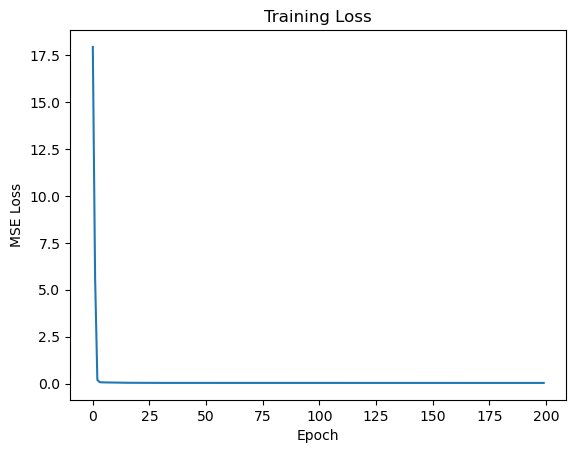

Training complete.


In [112]:
#Execute this cell to execute the training with the SinkkhornGED model
INPUT_DIM = 2 #(atomic_num, degree)
HIDDEN_DIM = 64  
SINKHORN_ITER = 10  # More iterations for better convergence
EPSILON = 0.005  # Lower epsilon for sharper matching
LR = 0.01
EPOCHS = 100
BATCH_SIZE = 128
WARMUP_EPOCHS = 2

# Initialize Model
model = SinkhornGED(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, sinkhorn_iter=SINKHORN_ITER, 
                    epsilon=EPSILON)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)  # AdamW for better regularization

# Cosine annealing with warmup
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)
scheduler_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, 
                                             schedulers=[scheduler_warmup, scheduler_cosine], 
                                             milestones=[WARMUP_EPOCHS])
criterion = nn.MSELoss()
def relative_loss(pred, target):
    return torch.mean(torch.abs(pred - target) / (target + 1))

# Dataset and DataLoader
class GEDDataset(Dataset):
    def __init__(self, x1, x2, n1, n2, y):
        self.x1 = x1
        self.x2 = x2
        self.n1 = n1
        self.n2 = n2
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x1[idx], self.x2[idx], self.n1[idx], self.n2[idx], self.y[idx]

train_dataset = GEDDataset(X1_train, X2_train, N1_train, N2_train, Y_train)
test_dataset = GEDDataset(X1_val, X2_val, N1_val, N2_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training Loop
print("Starting Sinkhorn GED Training...")
losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_loss_raw = 0
    for x1, x2, n1, n2, y in train_loader:
        optimizer.zero_grad()
        
        # Compute Sinkhorn distance
        pred = model(x1, x2, n1, n2)
        
        pred_raw = pred * y_std + y_mean
        y_raw = y * y_std + y_mean

        loss = criterion(pred, y)
        loss_raw = criterion(pred_raw, y_raw)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss_raw += loss_raw.item()

    avg_loss = epoch_loss / len(train_loader)
    avg_loss_raw = epoch_loss_raw / len(train_loader)
    losses.append(avg_loss)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_loss_raw = 0.0
        relative = 0.0
        target_sum = 0.0
        for x1, x2, n1, n2, y in test_loader:
            pred = model(x1, x2, n1, n2)
            pred_raw = pred * y_std + y_mean
            y_raw = y * y_std + y_mean
            val_loss += criterion(pred, y).item()
        
            target_sum += y_raw.sum().item()
            relative += relative_loss(pred_raw, y_raw).item()
            val_loss_raw += criterion(pred_raw, y_raw).item()

    val_loss /= len(test_loader)
    val_loss_raw /= len(test_loader)
    relative /= len(test_loader)
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Train raw loss: {avg_loss_raw:.4f}, Val Loss: {val_loss:.4f}, Val raw loss: {val_loss_raw:.4f}")
        print(f"Global Relative Error: {relative:.4f}")
# Plot Loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

print("Training complete.")

In [ ]:
y_true_all = []
y_pred_all = []
with torch.no_grad():
    for x1, x2, n1, n2, y in test_loader:
        pred = model(x1, x2, n1, n2)
        pred_raw = pred * y_std + y_mean
        y_raw = y * y_std + y_mean
        y_true_all.append(y_raw)
        y_pred_all.append(pred_raw)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
corr = np.corrcoef(y_true_all, y_pred_all)[0,1]

print(f"Final Test Results:\nMSE={mse:.4f}, RMSE={np.sqrt(mse):.4f}, MAE={mae:.4f}, R2={r2:.4f}, Corr={corr:.4f}")
plt.scatter(y_true_all, y_pred_all, s=10, alpha=0.5)
plt.plot([0,250],[0,250],'r--')
plt.xlabel("True GED")
plt.ylabel("Predicted GED")
plt.title("Predicted vs True GED on Test Set")
plt.show()


**Execute the cell below to execute the training with the DeepSets model**

Starting DeepSets Training...
Epoch 10/100, Train Loss: 0.0316, Train raw loss: 47.5909, Val Loss: 0.0477, Val raw loss: 71.8213
Global Relative Error: 0.1522
Epoch 20/100, Train Loss: 0.0223, Train raw loss: 33.6088, Val Loss: 0.0229, Val raw loss: 34.4269
Global Relative Error: 0.1531
Epoch 30/100, Train Loss: 0.0219, Train raw loss: 33.0295, Val Loss: 0.0248, Val raw loss: 37.4171
Global Relative Error: 0.1099
Epoch 40/100, Train Loss: 0.0188, Train raw loss: 28.3772, Val Loss: 0.0189, Val raw loss: 28.5002
Global Relative Error: 0.1215
Epoch 50/100, Train Loss: 0.0175, Train raw loss: 26.3691, Val Loss: 0.0190, Val raw loss: 28.6784
Global Relative Error: 0.0998
Epoch 60/100, Train Loss: 0.0166, Train raw loss: 24.9416, Val Loss: 0.0240, Val raw loss: 36.2105
Global Relative Error: 0.1008
Epoch 70/100, Train Loss: 0.0146, Train raw loss: 22.0036, Val Loss: 0.0160, Val raw loss: 24.0763
Global Relative Error: 0.1092
Epoch 80/100, Train Loss: 0.0139, Train raw loss: 20.9646, Val Loss

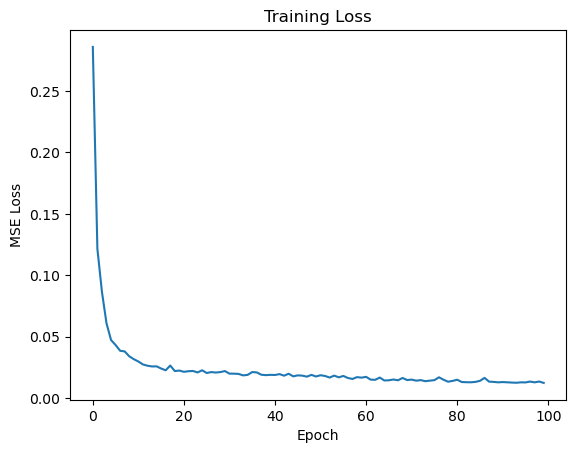

Training complete.


In [119]:
# DeepSets Model Hyperparameters
INPUT_DIM = 2 # (atomic_num, degree)
HIDDEN_DIM = 32
EMBEDDING_DIM = 64
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

# Initialize Models
encoder = DeepSets(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=EMBEDDING_DIM, aggregator='sum')
head = Head(emb_dim=EMBEDDING_DIM, hidden=HIDDEN_DIM)

optimizer = optim.Adam(list(encoder.parameters()) + list(head.parameters()), lr=LR)
criterion = nn.MSELoss()

# Dataset and DataLoader
class GEDDataset(Dataset):
    def __init__(self, x1, m1, x2, m2, y):
        self.x1 = x1
        self.m1 = m1
        self.x2 = x2
        self.m2 = m2
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x1[idx], self.m1[idx], self.x2[idx], self.m2[idx], self.y[idx]
    
def make_mask(lengths, max_len, device):
    # Creates [B, max_len] boolean mask
    return torch.arange(max_len, device=device).unsqueeze(0) < lengths.unsqueeze(1)


train_dataset = GEDDataset(X1_train, N1_train, X2_train, N2_train, Y_train)
test_dataset = GEDDataset(X1_val, N1_val, X2_val, N2_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training Loop
print("Starting DeepSets Training...")
losses = []
for epoch in range(EPOCHS):
    encoder.train();head.train()
    epoch_loss = 0
    epoch_loss_raw = 0
    for x1, m1, x2, m2, y in train_loader:
        optimizer.zero_grad()
        
        mask1 = make_mask(m1, x1.shape[1], x1.device)
        mask2 = make_mask(m2, x2.shape[1], x2.device)
        # Encode both graphs
        emb1 = encoder(x1, mask=mask1)
        emb2 = encoder(x2, mask=mask2)
        
        # Predict GED
        pred = head(emb1, emb2)
        
        pred_raw = pred * y_std + y_mean
        y_raw = y * y_std + y_mean
        loss = criterion(pred, y)
        loss_raw = criterion(pred_raw, y_raw)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss_raw += loss_raw.item()
        
    avg_loss = epoch_loss / len(train_loader)
    avg_loss_raw = epoch_loss_raw / len(train_loader)
    losses.append(avg_loss)
    encoder.eval()
    head.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_loss_raw = 0.0
        relative = 0.0
        for x1, m1, x2, m2, y in test_loader:

            mask1 = make_mask(m1, x1.shape[1], x1.device)
            mask2 = make_mask(m2, x2.shape[1], x2.device)
            emb1 = encoder(x1, mask=mask1)
            emb2 = encoder(x2, mask=mask2)
            pred = head(emb1, emb2)
            pred_raw = pred * y_std + y_mean
            y_raw = y * y_std + y_mean
            val_loss += criterion(pred, y).item()
            val_loss_raw += criterion(pred_raw, y_raw).item()
            relative += relative_loss(pred_raw, y_raw).item()
    val_loss /= len(test_loader)
    val_loss_raw /= len(test_loader)
    relative /= len(test_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Train raw loss: {avg_loss_raw:.4f}, Val Loss: {val_loss:.4f}, Val raw loss: {val_loss_raw:.4f}")
        print(f"Global Relative Error: {relative:.4f}")
# Plot Loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

print("Training complete.")

Final Test Results:
MSE=19.9666, RMSE=4.4684, MAE=3.2182, R2=0.9866, Corr=0.9934


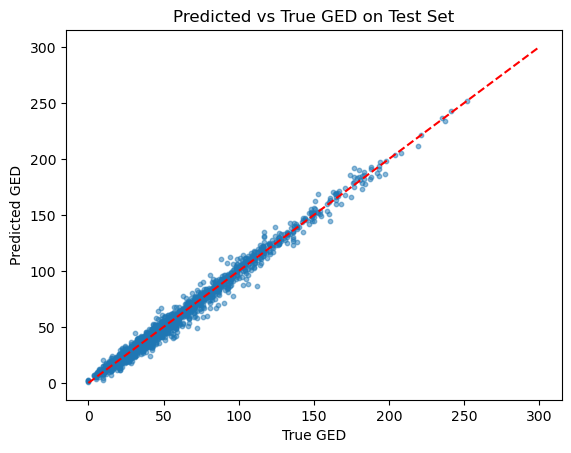

In [123]:
y_true_all = []
y_pred_all = []
with torch.no_grad():
    for x1, m1, x2, m2, y in test_loader:
        mask1 = make_mask(m1, x1.shape[1], x1.device)
        mask2 = make_mask(m2, x2.shape[1], x2.device)
        emb1 = encoder(x1, mask=mask1)
        emb2 = encoder(x2, mask=mask2)
        pred = head(emb1, emb2)
        pred_raw = pred * y_std + y_mean
        y_raw = y * y_std + y_mean
        y_true_all.append(y_raw)
        y_pred_all.append(pred_raw)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
corr = np.corrcoef(y_true_all, y_pred_all)[0,1]

print(f"Final Test Results:\nMSE={mse:.4f}, RMSE={np.sqrt(mse):.4f}, MAE={mae:.4f}, R2={r2:.4f}, Corr={corr:.4f}")
plt.scatter(y_true_all, y_pred_all, s=10, alpha=0.5)
plt.plot([0,300],[0,300],'r--')
plt.xlabel("True GED")
plt.ylabel("Predicted GED")
plt.title("Predicted vs True GED on Test Set")
plt.show()
